In [ ]:
!pip install -q langgraph autogen openai networkx matplotlib



This project is about building a Smart Health Assistant that acts like a virtual health guide.

First, it asks the user basic health details such as height, weight, age, gender, and food preference (veg / non-veg / vegan).
Then it calculates the user’s BMI (Body Mass Index) to understand whether the person is underweight, normal, or overweight.
Based on that result, the system gives health advice, suggests a personalized diet plan, and finally creates a weekly workout schedule suited to the user’s body type and lifestyle.

Instead of one single program doing everything, the system uses multiple intelligent agents, where:

One agent collects user details

Another calculates BMI

Another gives health advice

Another plans meals

Another schedules workouts

All of them work step by step like a team, passing information to each other, so the final result is a complete, personalized health plan for the user.

In simple words:
“It is an AI-based personal health coach that understands your body and suggests what to eat and how to exercise.”

Multi-agent autonomous health assistant using:

✔ Grok API as the LLM
✔ LangGraph-style routing (nodes + edges)
✔ Guest + authenticated user handling (session_id / user_id)
✔ SQLite persistent memory (per agent, per user)
✔ Multi-user concurrency simulation
✔ “Last time we spoke…” memory retrieval

In [ ]:
#STEP 2 – Imports & Configuration
import os
from typing import TypedDict
import networkx as nx
import matplotlib.pyplot as plt

from autogen import AssistantAgent
from langgraph.graph import StateGraph



In [ ]:
#STEP 3 – Grok API Configuration
os.environ["OPENAI_API_KEY"] = ""

llm_config = {
    "model": "llama-3.1-8b-instant",   # Groq-supported model
    "api_key": os.environ["OPENAI_API_KEY"],
    "base_url": "https://api.groq.com/openai/v1",
    "temperature": 0
}


In [ ]:
#CELL 4: DEFINE SHARED STATE
from pydantic import BaseModel, Field




In [ ]:
#CELL 5: BMI TOOL
def calculate_bmi(height_cm: float, weight_kg: float) -> dict:
    height_m = height_cm / 100
    bmi = weight_kg / (height_m ** 2)
    return {
        "height_m": round(height_m, 2),
        "bmi": round(bmi, 2)
    }


In [ ]:
#CELL 6: CREATE ASSISTANT AGENTS
bmi_agent = AssistantAgent(
    name="BMIAgent",
    system_message="Analyze BMI and provide health recommendations.",
    llm_config=llm_config,
)

diet_agent = AssistantAgent(
    name="DietPlannerAgent",
    system_message="Create a personalized diet plan based on BMI insight and dietary preference.",
    llm_config=llm_config,
)

workout_agent = AssistantAgent(
    name="WorkoutSchedulerAgent",
    system_message="Create a weekly workout plan based on diet plan, age, and gender.",
    llm_config=llm_config,
)


In [ ]:
#CELL 7: LANGGRAPH NODES (SEQUENTIAL EXECUTION)
#STEP 1: USER DATA
def user_input_node(state: HealthState) -> HealthState:
    print("STEP 1: Collecting User Data")

    state["height_cm"] = 172
    state["weight_kg"] = 75
    state["age"] = 28
    state["gender"] = "male"
    state["dietary_preference"] = "veg"

    return state



In [ ]:
#STEP 2: BMI CALCULATION
def bmi_tool_node(state: HealthState) -> HealthState:
    print("STEP 2: Calculating BMI")

    result = calculate_bmi(
        height_cm=state["height_cm"],
        weight_kg=state["weight_kg"]
    )

    state["bmi"] = result["bmi"]
    return state




In [ ]:
#STEP 3: BMI ANALYSIS (LLM CALL)
def bmi_agent_node(state: HealthState) -> HealthState:
    print("STEP 3: BMI Agent Analysis")

    prompt = f"""
User BMI: {state['bmi']}
Classify BMI category and provide health recommendations.
"""

    response = bmi_agent.generate_reply(
        messages=[{"role": "user", "content": prompt}]
    )

    state["bmi_insight"] = response
    return state


In [ ]:
#STEP 4: DIET PLANNING
def diet_agent_node(state: HealthState) -> HealthState:
    print("STEP 4: Diet Planning")

    prompt = f"""
BMI Insight:
{state['bmi_insight']}

Dietary Preference: {state['dietary_preference']}
Create a personalized meal plan.
"""

    response = diet_agent.generate_reply(
        messages=[{"role": "user", "content": prompt}]
    )

    state["diet_plan"] = response
    return state



In [ ]:
#STEP 5: WORKOUT SCHEDULING
def workout_agent_node(state: HealthState) -> HealthState:
    print("STEP 5: Workout Scheduling")

    prompt = f"""
Diet Plan:
{state['diet_plan']}

Age: {state['age']}
Gender: {state['gender']}
Create a weekly workout schedule.
"""

    response = workout_agent.generate_reply(
        messages=[{"role": "user", "content": prompt}]
    )

    state["workout_plan"] = response
    return state


In [ ]:
#CELL 8: BUILD LANGGRAPH
graph = StateGraph(HealthState)

graph.add_node("UserInput", user_input_node)
graph.add_node("BMICalc", bmi_tool_node)
graph.add_node("BMIAnalysis", bmi_agent_node)
graph.add_node("DietPlan", diet_agent_node)
graph.add_node("WorkoutPlan", workout_agent_node)

graph.add_edge("UserInput", "BMICalc")
graph.add_edge("BMICalc", "BMIAnalysis")
graph.add_edge("BMIAnalysis", "DietPlan")
graph.add_edge("DietPlan", "WorkoutPlan")

graph.set_entry_point("UserInput")

workflow = graph.compile()



In [ ]:
#CELL 9: EXECUTE
final_output = workflow.invoke({})

print("\nFINAL HEALTH PLAN\n")
print("BMI:", final_output["bmi"])
print("\nBMI Insight:\n", final_output["bmi_insight"])
print("\nDiet Plan:\n", final_output["diet_plan"])
print("\nWorkout Plan:\n", final_output["workout_plan"])





STEP 1: Collecting User Data
STEP 2: Calculating BMI
STEP 3: BMI Agent Analysis
[autogen.oai.client: 01-16 06:47:23] {734} WARNING - Model llama-3.1-8b-instant is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.


STEP 4: Diet Planning
[autogen.oai.client: 01-16 06:47:24] {734} WARNING - Model llama-3.1-8b-instant is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.


STEP 5: Workout Scheduling
[autogen.oai.client: 01-16 06:47:25] {734} WARNING - Model llama-3.1-8b-instant is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.



FINAL HEALTH PLAN

BMI: 25.35

BMI Insight:
 Based on your BMI of 25.35, I would classify your BMI category as:

**Overweight**

According to the World Health Organization (WHO), a BMI of 25-29.9 falls into the overweight category.

Here are some health recommendations for you:

1. **Maintain a healthy weight**: Aim to lose 5-10% of your current weight to reduce your risk of chronic diseases such as diabetes, heart disease, and certain types of cancer.
2. **Eat a balanced diet**: Focus on whole, unprocessed foods like vegetables, fruits, whole grains, lean proteins, and healthy fats. Avoid sugary drinks and foods high in saturated and trans fats.
3. **Increase physical activity**: Aim for at least 150 minutes of moderate-intensity aerobic exercise, or 75 minutes of vigorous-intensity aerobic exercise, or a combination of both, per week. You can also incorporate strength-training exercises to build muscle and boost metabolism.
4. **Monitor your waist circumference**: If your waist circ

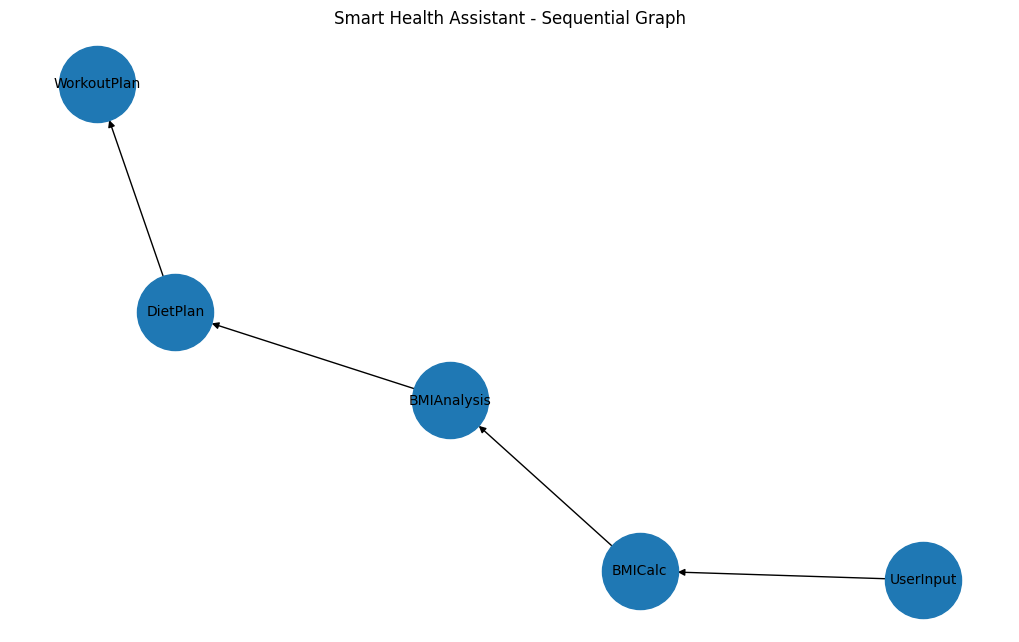

In [ ]:
#CELL 10: GRAPH VISUALIZATION
G = nx.DiGraph()

edges = [
    ("UserInput", "BMICalc"),
    ("BMICalc", "BMIAnalysis"),
    ("BMIAnalysis", "DietPlan"),
    ("DietPlan", "WorkoutPlan")
]

G.add_edges_from(edges)

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, font_size=10)
plt.title("Smart Health Assistant - Sequential Graph")
plt.show()

